# Project 242

## Import

In [324]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [325]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## I. Data

### 1. Load data

In [326]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


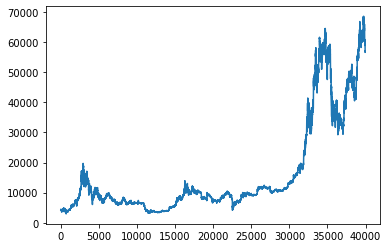

In [327]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### 2. Preprocess data

- clean data
- add features

In [328]:
# Clean data
data = clean_data(data)
data = data.rename(columns = {'Volume USDT': 'Volume'})

In [329]:
# Add features
data = add_technical_indicators(data, lookback_period=30)[30:]

In [330]:
data.loc[data['VWAP'].isna(), 'VWAP'] = 0

In [331]:
# Split data
train_data, test_data = split_data(data, split=0.25)


In [332]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [333]:
# Add Signal
train_data = add_signal(train_data, 0.001)
test_data = add_signal(test_data, 0.001)

In [334]:
train = prepare_data_2D_format(train_data, lookback_period = 30, undersample = True)
test = prepare_data_2D_format(test_data, lookback_period = 30, undersample = False)
test = test[:-30]

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


## II. Model

In [335]:
from sklearn.linear_model import LogisticRegression
# Create MLR model
logistic_regression = LogisticRegression(multi_class="multinomial")

# Train
log = logistic_regression.fit(train.drop(['Signal'], axis = 1), train['Signal'])

# Check score
y_pred = log.predict(test.drop(['Signal'], axis = 1))
y_test = test['Signal']

### 3. Test prediction model

In [336]:
y = log.predict(train.drop(['Signal'], axis = 1))
ACC = get_ACC(train['Signal'], y)
ACC

0.36570561456752654

In [337]:
TPR, FPR = 0, 0#get_TPR_FPR(y_test, y_pred)
F1 = 0#get_F1(y_test, y_pred)
ACC = get_ACC(y_test, y_pred)
WACC = 0#get_WACC(y_test, y_pred, test_data.close)

In [338]:
models = ['Baseline']
metrics = ['TPR', 'FPR', 'ACC', 'F1', 'WACC']
metric_data = [[TPR, FPR, ACC, F1, WACC]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,TPR,FPR,ACC,F1,WACC
Baseline,0,0,0.21466,0,0


### III. Strategy

### 1. Get data ready for backtesting

In [339]:
signal = pd.Series(y_pred)
close = test_data.close
signal.describe()

count    9918.000000
mean       -0.027223
std         0.365201
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
dtype: float64

In [340]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
close_crop = crop_window(close, nb_days)

### 2. Backtesting

In [341]:
strat = Strategy(cash=500, fees=0.001)

In [342]:
strat.run(signal_crop, close_crop, verbose=False)

In [343]:
wallet = np.array(strat.wallet)
profit_list = [0]
for i in range(1, len(wallet)):
    profit_list.append(wallet[i]-wallet[i-1])
    
profit = np.array(profit_list)

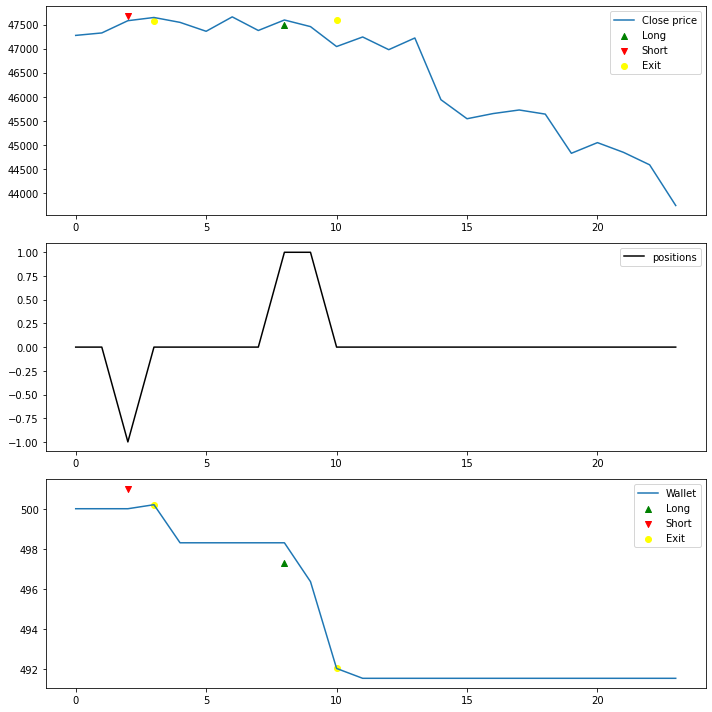

In [344]:
strat.visualize()

### 3. Test performance startegy

In [345]:
l_SharpeRatio = SharpeRatio(profit)
l_MaxDrawback = MaxDrawback(profit)
l_WinLossRatio = WinLossRatio(profit)
l_CumulativeProfit = CumulativeProfit(profit)
l_MeanProfit = MeanProfit(profit)

In [346]:
models = ['Baseline']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[l_SharpeRatio, l_MaxDrawback, l_WinLossRatio, l_CumulativeProfit, l_MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,SharpeRatio,MaxDrawback,WinLossRatio,CumulativeProfit,MeanProfit
Baseline,-0.348746,-4.330739,0.25,-8.460224,-0.338409
